In [1]:
!pip install scikit-learn

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import files, drive
import os
import cv2
import random
import pickle
from IPython.display import clear_output
from PIL import Image
import sklearn

In [3]:
def load_dataset():
    if os.path.exists('/content/brain_tumor_mri'):
        return

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes.'.format(name=fn, length=len(uploaded[fn])))

    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d jarvisgroot/brain-tumor-classification-mri-images
    !unzip brain-tumor-classification-mri-images.zip
    clear_output()

def load_dataset_drive():
    drive.mount('/content/drive')
    !mkdir -p ~/.kaggle/ && cp drive/MyDrive/Datasets/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d jarvisgroot/brain-tumor-classification-mri-images
    !unzip brain-tumor-classification-mri-images.zip
    clear_output()

def setup_dataset():
    data_path = '/content/brain_tumor_mri/new_dataset/bt_images'

    training_data_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/training_data.pickle')
    labels_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/labels.pickle')
    test_data_path = os.path.join(data_path, '/content/test_images-20210704T210303Z-001/test_images')

    with open(training_data_path, 'rb') as training_data_file:
        training_data = pickle.load(training_data_file)

    random.shuffle(training_data)

    X = []
    y = []

    for features, labels in training_data:
        X.append(features)
        y.append(labels)

    X = np.array(X).reshape(-1, 512, 512, 3)
    y = np.array(y)
    y = y - 1

    return X, y

def setup_dataset_images():
    data_path = '/content/brain_tumor_mri/new_dataset/bt_images'

    training_data_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/training_data.pickle')
    labels_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/labels.pickle')
    test_data_path = os.path.join(data_path, '/content/test_images-20210704T210303Z-001/test_images')

    with open(labels_path, 'rb') as labels_file:
        labels = training_data = pickle.load(labels_file)

    labels = np.array(labels)
    labels = labels - 1

    image_data = []

    for i in range(3064):
        image_file = f"{i + 1}.jpg"
        image_path = os.path.join(data_path, image_file)
        img = Image.open(image_path)

        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
        image_array = tf.keras.preprocessing.image.img_to_array(img)
        # image_array = np.expand_dims(image_array, axis=0)
        image_array = tf.keras.applications.inception_v3.preprocess_input(image_array)

        image_data.append(image_array)
        del image_array

    image_data = np.array(image_data)
    sklearn.utils.shuffle(image_data, labels)

    return image_data, labels

In [4]:
load_dataset()

training_data, labels = setup_dataset_images()

In [5]:
pretrained_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(256, 256, 3),
    pooling=None,
    classes=3,
    classifier_activation="softmax",
)

In [6]:
model = tf.keras.models.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22328099 (85.17 MB)
Trainable params: 22293667 (85.04 MB)
Non-trainable params: 34432 (134.50 KB)
__________

In [7]:
model.compile(
    optimizer="adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(training_data, labels, batch_size=16, epochs=20, validation_split=0.1)

Epoch 1/20
173/173 [==============================] - 84s 222ms/step - loss: 0.8478 - accuracy: 0.6888 - val_loss: 34.2125 - val_accuracy: 0.0033
Epoch 2/20
173/173 [==============================] - 31s 181ms/step - loss: 0.5164 - accuracy: 0.8045 - val_loss: 1.7788 - val_accuracy: 0.2769
Epoch 3/20
173/173 [==============================] - 31s 180ms/step - loss: 0.4461 - accuracy: 0.8255 - val_loss: 0.4061 - val_accuracy: 0.8730
Epoch 4/20
173/173 [==============================] - 31s 180ms/step - loss: 0.4005 - accuracy: 0.8473 - val_loss: 3.8773 - val_accuracy: 0.1857
Epoch 5/20
173/173 [==============================] - 31s 180ms/step - loss: 0.4097 - accuracy: 0.8480 - val_loss: 0.3431 - val_accuracy: 0.9218
Epoch 6/20
173/173 [==============================] - 31s 180ms/step - loss: 0.3840 - accuracy: 0.8538 - val_loss: 16.6260 - val_accuracy: 0.0130
Epoch 7/20
173/173 [==============================] - 31s 180ms/step - loss: 0.3152 - accuracy: 0.8770 - val_loss: 2.9475 - val_

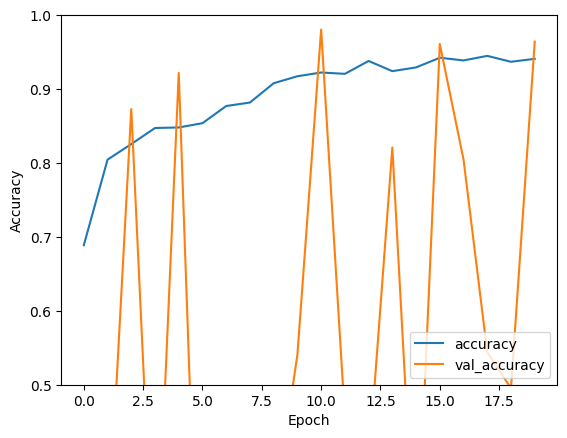

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [9]:
# model.save('test_model.model')

# !zip -r test_model.zip test_model.model/
# !mv test_model.zip drive/MyDrive/Datasets/

In [10]:
# file_size = os.path.getsize('drive/MyDrive/Datasets/test_model.zip')
# print("File Size is :", file_size, "bytes")

In [11]:
data_path = '/content/brain_tumor_mri/new_dataset/bt_images'

training_data_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/training_data.pickle')
labels_path = os.path.join(data_path, '/content/brain_tumor_mri/new_dataset/labels.pickle')
test_data_path = os.path.join(data_path, '/content/test_images-20210704T210303Z-001/test_images')

In [12]:
test_data = []

for img in os.listdir(test_data_path):
    img_array = cv2.imread(os.path.join(test_data_path, img))
    test_data.append([img_array])

In [13]:
test_data = np.array(test_data).reshape(-1, 512, 512, 3)

In [14]:
# predictions = model.predict([test_data])
# print(np.argmax(predictions[0]))

In [15]:
# plt.imshow(test_data[0])
# plt.show()